# Designing Communication Topologies via Graph Neural Networks
Fengjun Yang, Anish Battacharya, Nikolai Matni (2021)

In [218]:
%load_ext autoreload
%autoreload 2

# Useful Libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import networkx as nx

# Source Files
import grnn, exp_utils, controller
import env.dlqr

# Other bookkeeping
%matplotlib inline
np.set_printoptions(precision=3)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

## How to train and run the GRNN model

In [221]:
# Create an environment
N = 20
T = 50
p, q = 1, 1
degree = 5 + 1     # All nodes are assumed to have a self-loop, hence the +1

# Generate environment (here an LQR environment)
dlqrenv, G = env.dlqr.generate_lq_env(N, degree, device)
nx.draw_kamada_kawai(G)

In [223]:
# Define training loss
def criterion(x_traj, u_traj, env, model):
    return env.cost(x_traj, u_traj)

In [224]:
# Create model
hidden_state_dim = 5
S = dlqrenv.S.clone()
model = grnn.GRNN(S, N, T, p, q, hidden_state_dim, S_trainable=True).to(device)

In [225]:
# Train model
model = exp_utils.train_model(model, dlqrenv, criterion, num_epoch=100, verbose=True)

Epoch: 1 	 Loss: 2402.880395271219
Epoch: 11 	 Loss: 19.815188514410387
Epoch: 21 	 Loss: 19.48428334850779
Epoch: 31 	 Loss: 20.77766577247454
Epoch: 41 	 Loss: 21.928673545440617
Epoch: 51 	 Loss: 21.6360570042124
Epoch: 61 	 Loss: 20.312759913806023
Epoch: 71 	 Loss: 23.146689814935165
Epoch: 81 	 Loss: 25.484741933340423
Epoch: 91 	 Loss: 24.660094906109183


In [226]:
# Define controllers we want to compare to
lqrctrl = dlqrenv.get_optimal_controller()
grnnctrl = model.get_controller()
zeroctrl = controller.ZeroController(N, q)
randctrl = controller.RandomController(N, q)
controllers = [lqrctrl, grnnctrl, zeroctrl, randctrl]
names = ['Global Optimal', 'GRNN', 'Autonomous', 'Random']

In [227]:
# Simulate each controller forward from the same initial condition
x0 = dlqrenv.random_x0()
xs, us, costs = exp_utils.sim_controllers(dlqrenv, x0, controllers, T, x0.device)
exp_utils.plot_controllers(xs, names, costs, 0)

## Experiment 1: GRNN on LQR Systems with Given Communication Topology

In [382]:
# Parameters for the model
model_params = {
    'N':20,
    'T':50,
    'p':1,
    'q':1,
    'h':5,
    'S_trainable':True
}
use_given_support = True

# Additional controllers to compare to
zeroctrl = controller.ZeroController(N, q)
randctrl = controller.RandomController(N, q)
additional_controllers = [zeroctrl, randctrl]
num_controllers = len(additional_controllers) + 2

# Training loss
def criterion(x_traj, u_traj, env, model):
    return env.cost(x_traj, u_traj)

# Experiment parameters
num_topologies = 50
num_x0s = 100
num_epoch = 100
verbose = True

In [383]:
# Evaluate the performance of GRNN
total_rel_costs = np.zeros(num_controllers)
relative_ind = 0

for counter in range(num_topologies):
    # Generate an environment
    dlqrenv, G = env.dlqr.generate_lq_env(N, degree, device)
    
    # Generate and train model
    if use_given_support:
        S = dlqrenv.S.clone()
    else:
        S = None
    model = grnn.GRNN(S, **model_params).to(device)
    model = exp_utils.train_model(model, dlqrenv, criterion, num_epoch=num_epoch)
    
    # Test the performance of GRNN on this env
    total_rel_costs += exp_utils.estimate_grnn_cost(
        dlqrenv, model, T, additional_controllers, num_x0s=num_x0s)
    
    # Print progress
    if verbose:
        print('Iteration {}:\t{}'.format(counter+1, total_rel_costs / (counter+1)))

# Print result
print(total_rel_costs / num_topologies)

Iteration 1:	[ 1.     1.141  2.521 72.153]
Iteration 2:	[ 1.     1.192  2.24  64.444]
Iteration 3:	[ 1.     1.156  1.881 64.524]
Iteration 4:	[ 1.     1.144  1.995 63.525]
Iteration 5:	[ 1.     1.127  1.815 64.016]
Iteration 6:	[ 1.     1.12   1.848 64.135]
Iteration 7:	[ 1.     1.115  1.943 66.446]
Iteration 8:	[ 1.     1.149  2.056 71.322]
Iteration 9:	[ 1.     1.148  2.116 71.41 ]
Iteration 10:	[ 1.     1.138  2.021 68.677]
Iteration 11:	[ 1.     1.152  1.984 67.227]
Iteration 12:	[ 1.     1.169  2.008 66.935]
Iteration 13:	[ 1.     1.164  2.023 65.35 ]
Iteration 14:	[ 1.     1.177  2.053 65.54 ]
Iteration 15:	[ 1.     1.178  2.012 65.489]
Iteration 16:	[ 1.     1.176  1.991 65.705]
Iteration 17:	[ 1.     1.184  1.966 64.339]
Iteration 18:	[ 1.     1.18   2.001 66.004]
Iteration 19:	[ 1.     1.175  2.014 66.336]
Iteration 20:	[ 1.     1.17   1.98  66.544]
Iteration 21:	[ 1.     1.176  1.997 66.996]
Iteration 22:	[ 1.     1.225  1.985 66.728]
Iteration 23:	[ 1.     1.221  1.966 66.49

KeyboardInterrupt: 

## Experiment 2: Generate Communication Topology w/ GRNN

In [359]:
# Parameters for the model
model_params = {
    'N':20,
    'T':50,
    'p':1,
    'q':1,
    'h':5,
    'S_trainable':True
}
use_given_support = False

# Additional controllers to compare to
zeroctrl = controller.ZeroController(N, q)
randctrl = controller.RandomController(N, q)
additional_controllers = [zeroctrl, randctrl]
num_controllers = len(additional_controllers) + 2

# Training loss
beta = 1
def criterion(x_traj, u_traj, env, model):
    global beta
    return env.cost(x_traj, u_traj) + beta * torch.sum(torch.abs(model.S_()))

# Experiment parameters
num_epoch = 100
batch_size = 20
verbose = True
threshold = 1e-3
betas = np.logspace(-5, 2, 10)

In [360]:
S_weights = np.zeros((len(betas), N*N))
costs = np.zeros(len(betas))

dlqrenv, G = env.dlqr.generate_lq_env(N, degree, device)
for i, beta in enumerate(betas):
    grnn_S = exp_utils.grnn_topology(
        dlqrenv, criterion, model_params, threshold, device, num_epoch=num_epoch)
    S_weights[i] = grnn_S.cpu().numpy().flatten()
    new_S = grnn_S.clone()
    new_S[new_S < threshold] = 0
    model = grnn.GRNN(S, **model_params).to(device)
    model = exp_utils.train_model(model, dlqrenv, criterion, num_epoch=num_epoch)
    costs[i] = exp_utils.estimate_grnn_cost(dlqrenv, model, T)[1]

Text(0, 0.5, 'LQR Cost')

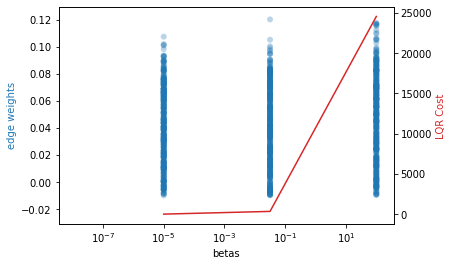

In [379]:
fig = plt.figure()
ax = plt.gca()
ax.set_xscale('log')
for i, beta in enumerate(betas):
    ax.scatter(np.ones(N*N)*beta, S_weights[i], c='tab:blue', alpha=0.3, edgecolors='none')
    
ax.set_xlabel('betas')
ax.set_ylabel('edge weights', color='tab:blue')

ax2 = ax.twinx()
ax2.plot(betas, costs, c='tab:red')
ax2.set_ylabel('LQR Cost', color='tab:red')
#plt.savefig('losssparsity.png', dpi=300)

## Experiment 3: Unstable A

In [329]:
dlqrenv, G = env.dlqr.generate_lq_env(20, 5, device, A_norm=1, AB_hops=3)
nx.radius(G), nx.diameter(G)

1.0
tensor(1.5838, dtype=torch.float64)


(4, 7)

In [327]:
print(np.linalg.norm(dlqrenv.A, ord=2))

0.9999999999999996
